# House Price Prediction Model

Before running this notebook, be sure run [Data Wrangling](data_wrangling.ipynb) jupyter notebook to obtain the dataset for training the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()
%matplotlib inline

In [2]:
# load data
df_data = pd.read_pickle('data/house_price_w_temp.pkl')
df_data.head()

,Division,Region,State,State Code,City,Year,Month,StateAvgYearlyTemp,CityAvgYearlyTemp,AvgHousePrice,...,State__South Dakota,State__Tennessee,State__Texas,State__Utah,State__Vermont,State__Virginia,State__Washington,State__West Virginia,State__Wisconsin,State__Wyoming
0,Pacific,West,Alaska,AK,Anchorage,1996,1,35.700792,37.416278,124475.0,...,0,0,0,0,0,0,0,0,0,0
1,East South Central,South,Alabama,AL,Auburn,1996,1,63.960195,63.960195,129520.0,...,0,0,0,0,0,0,0,0,0,0
2,East South Central,South,Alabama,AL,Autaugaville,1996,1,63.960195,63.960195,79769.0,...,0,0,0,0,0,0,0,0,0,0
3,East South Central,South,Alabama,AL,Bay Minette,1996,1,63.960195,63.960195,59125.0,...,0,0,0,0,0,0,0,0,0,0
4,East South Central,South,Alabama,AL,Berry,1996,1,63.960195,63.960195,65718.0,...,0,0,0,0,0,0,0,0,0,0


## House Price Model Class

In [3]:
class HousePriceModel:
    
    def __init__(self, model_name, param, features):
        self.model_name = model_name
        pipe = Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42))])
        self.model = GridSearchCV(estimator=pipe, param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.y_error = None
    
    def evaluate(self, X_train, y_train, X_test, y_test):
        self.y_train = y_train
        start_time = time.time()
        self.model.fit(X_train, y_train)
        stop_time = time.time()
        self.y_predict = np.round(self.model.predict(X_test), 1)
        self.residuals = pd.DataFrame(columns=['Residuals'])
        self.residuals['Residuals'] = y_test - self.y_predict
        mse = mean_squared_error(y_test, self.y_predict)
        metrics_dict = {'model_name': self.model_name,
                        'mse': mse,             # mean squared error
                        'rmse': np.sqrt(mse),   # relative mean squared error
                        'mae': mean_absolute_error(y_test, self.y_predict),     # mean absolute error
                        'R-squared': self.model.score(X_train, y_train),
                        'training_time': stop_time - start_time}  
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        
        # sort feature importance in descending order
        self.feature_imp = pd.Series(self.model.best_estimator_._final_estimator.feature_importances_, 
                                index=self.features).sort_values(ascending=False)
    
    def plot_feature_importance(self, figsize=(6, 6)):
        fig, ax = plt.subplots(figsize=figsize)
        
        # create a bar plot of feature importance
        sns.barplot(x=self.feature_imp, y=self.feature_imp.index)

        # add labels to graph
        plt.xlabel('Score', size=13)
        plt.ylabel('Features', size=13)
        plt.title('Feature Importance', size=15)
        plt.show()

## Split Data intro Train/Test

In [4]:
from sklearn.model_selection import train_test_split

y = df_data['AvgHousePrice']   # target variable
X = df_data

# split data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# create data frame for residuals
residuals = pd.DataFrame(columns=['State', 'City'])
residuals['State'] = X_test['State']
residuals['City'] = X_test['City']

# exclude first 5 features from model prediction
X_train = X_train[df_data.columns[5:]].drop(['AvgHousePrice', 'StateAvgYearlyTemp'], axis=1)
X_test = X_test[df_data.columns[5:]].drop(['AvgHousePrice', 'StateAvgYearlyTemp'], axis=1)

## Base Model

In [5]:
param = {'rf__n_estimators': [5]}
base_model = HousePriceModel('base_model', param, list(X_train.columns))
base_model.evaluate(X_train, y_train, X_test, y_test)
base_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


,model_name,mse,rmse,mae,R-squared,training_time
0,base_model,2.905918e+10,170467.54747,75903.210443,0.223125,343.21671


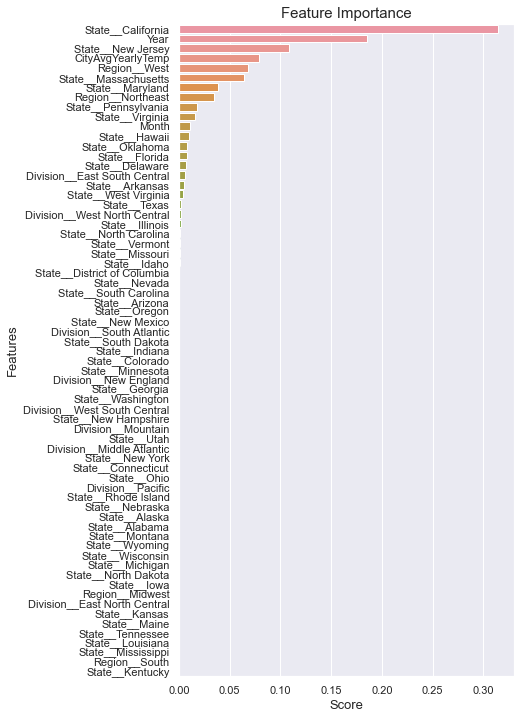

In [6]:
base_model.plot_feature_importance((6,12))

## Model with Less Features

In [7]:
# exclude states from the model
features = X_train.columns[:16]
model1 = HousePriceModel('model 1', param, list(features))
model1.evaluate(X_train[features], y_train, X_test[features], y_test)
model1.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.6s finished


,model_name,mse,rmse,mae,R-squared,training_time
0,model 1,2.905920e+10,170467.589001,75897.703197,0.223127,104.731635


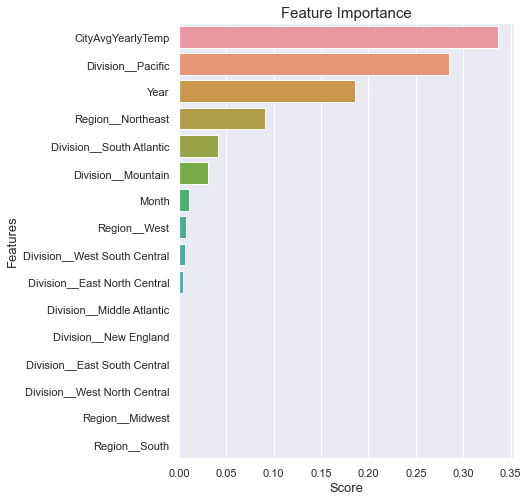

In [8]:
model1.plot_feature_importance((6,8))

Since model1 uses less features, has shorter training time and the error scores are almost the same as the base model's error scores, we use model1 to make house price prediction.

## Model's Prediction

In [9]:
import pickle

# load df_states for information lookup
df_states = pickle.load(open('web_app/df_states.sav', 'rb'))
df_states.head()

,State,State Code,Region,Division,City,CityAvgYearlyTemp
0,Alaska,AK,West,Pacific,Anchorage,37.416278
1,Alaska,AK,West,Pacific,Fairbanks,27.802421
2,Alaska,AK,West,Pacific,Juneau,41.883678
3,Alabama,AL,South,East South Central,Birmingham,63.142865
4,Alabama,AL,South,East South Central,Huntsville,61.292728


In [10]:
# now look for the states having temperature in the specified range
min_temp = 60
max_temp = 75

# get all states having the avg yearly temperature in range
temp = df_states[(df_states.CityAvgYearlyTemp >= min_temp) & (df_states.CityAvgYearlyTemp <= max_temp)]
temp

,State,State Code,Region,Division,City,CityAvgYearlyTemp
3,Alabama,AL,South,East South Central,Birmingham,63.142865
4,Alabama,AL,South,East South Central,Huntsville,61.292728
5,Alabama,AL,South,East South Central,Mobile,66.595995
6,Alabama,AL,South,East South Central,Montgomery,64.809193
7,Arkansas,AR,South,West South Central,Fort Smith,61.345895
8,Arkansas,AR,South,West South Central,Little Rock,62.247331
10,Arizona,AZ,West,Mountain,Phoenix,74.887184
11,Arizona,AZ,West,Mountain,Tucson,69.786108
12,Arizona,AZ,West,Mountain,Yuma,64.030149
13,California,CA,West,Pacific,Fresno,64.550491


In [11]:
# perform one-hot-encodings
temp = pd.concat([temp, pd.get_dummies(temp['Region'], prefix='Region_')], axis=1)
temp = pd.concat([temp, pd.get_dummies(temp['Division'], prefix='Division_')], axis=1)
temp.head()

,State,State Code,Region,Division,City,CityAvgYearlyTemp,Region__South,Region__West,Division__East South Central,Division__Mountain,Division__Pacific,Division__South Atlantic,Division__West South Central
3,Alabama,AL,South,East South Central,Birmingham,63.142865,1,0,1,0,0,0,0
4,Alabama,AL,South,East South Central,Huntsville,61.292728,1,0,1,0,0,0,0
5,Alabama,AL,South,East South Central,Mobile,66.595995,1,0,1,0,0,0,0
6,Alabama,AL,South,East South Central,Montgomery,64.809193,1,0,1,0,0,0,0
7,Arkansas,AR,South,West South Central,Fort Smith,61.345895,1,0,0,0,0,0,1


In [12]:
temp.shape

(51, 13)

In [13]:
# build inputs data frame for house price estimate
inputs = pd.DataFrame(columns=features)

for feature in features:
    if feature in list(temp.columns[4:]):
        inputs[feature] = temp[feature]

# fill in month and year
inputs['Month'] = 3
inputs['Year'] = 2021

# fill missing values with 0
inputs.fillna(0, inplace=True)
inputs.head()

,Year,Month,CityAvgYearlyTemp,Region__Midwest,Region__Northeast,Region__South,Region__West,Division__East North Central,Division__East South Central,Division__Middle Atlantic,Division__Mountain,Division__New England,Division__Pacific,Division__South Atlantic,Division__West North Central,Division__West South Central
3,2021,3,63.142865,0,0,1,0,0,1,0,0,0,0,0,0,0
4,2021,3,61.292728,0,0,1,0,0,1,0,0,0,0,0,0,0
5,2021,3,66.595995,0,0,1,0,0,1,0,0,0,0,0,0,0
6,2021,3,64.809193,0,0,1,0,0,1,0,0,0,0,0,0,0
7,2021,3,61.345895,0,0,1,0,0,0,0,0,0,0,0,0,1


In [14]:
inputs.shape

(51, 16)

In [15]:
# build outputs table
outputs = pd.DataFrame(columns=['State', 'City', 'CityAvgYearlyTemp', 'PredictedPrice'])
outputs['State'] = temp['State']
outputs['City'] = temp['City']
outputs['CityAvgYearlyTemp'] = inputs['CityAvgYearlyTemp']
outputs['PredictedPrice'] = np.round(model1.model.predict(inputs), 2)
outputs

,State,City,CityAvgYearlyTemp,PredictedPrice
3,Alabama,Birmingham,63.142865,64526.40
4,Alabama,Huntsville,61.292728,145867.88
5,Alabama,Mobile,66.595995,127752.20
6,Alabama,Montgomery,64.809193,91353.60
7,Arkansas,Fort Smith,61.345895,107858.72
8,Arkansas,Little Rock,62.247331,151485.20
10,Arizona,Phoenix,74.887184,272436.55
11,Arizona,Tucson,69.786108,229476.44
12,Arizona,Yuma,64.030149,225010.47
13,California,Fresno,64.550491,408846.60


In [16]:
# show only location the meet the price's range
min_price = 130000
max_price = 180000

outputs[(outputs.PredictedPrice >= min_price) & (outputs.PredictedPrice <= max_price)]

,State,City,CityAvgYearlyTemp,PredictedPrice
4,Alabama,Huntsville,61.292728,145867.88
8,Arkansas,Little Rock,62.247331,151485.20
26,Florida,Daytona Beach,69.212314,161671.20
36,Georgia,Savannah,65.740623,167004.60
57,Louisiana,Lake Charles,68.194502,179647.20
76,Mississippi,Tupelo,61.978237,145867.88
107,Oklahoma,Oklahoma City,60.116942,140863.00
121,South Carolina,Columbia,63.887618,152088.77
124,Tennessee,Chattanooga,60.592987,160533.41
128,Texas,Abilene,64.065243,136904.00


## Save Model

In [17]:
pickle.dump(model1, open('web_app/model.sav', 'wb'))               # save model
pickle.dump(features, open('web_app/features.sav', 'wb'))          # save features

# export residuals data frame to csv
residuals['Residuals'] = model1.residuals['Residuals']
residuals.to_csv('web_app/residuals.csv', index=False)      